# PEC2 - Visualización de datos
En este cuaderno vamos a mostrar tres tipos diferentes de visualizaciones para la PEC2 de Visualizacion de datos del Master de Ciencia de Datos de la UOC (2022)

Las tres gráficas que vamos a ver son:

- Cartograma
- Parallel Coordinates Plot
- Connected Scatterplot

Nota: Para generar las gráficas tenemos que tener activo el entorno de ejecución `gis_project`
Nota 2: Para conseguir una salida más limpia y con menos texto, vamos a suprimir los warnings en este cuaderno

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Cartograma

### Preparación de los datos

In [2]:
# General imports for Geopandas and Geoplot
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc
import requests
import pandas as pd
import os

In [3]:
# Basado en el ejemplo de la librería Geoplot: https://residentmario.github.io/geoplot/gallery/plot_obesity.html

# Datos de vulnerabilidad territorial agregados por distrito obtenidos del Informe de vulnerabilidad de la ciudad de Madrid:
# https://iguala.madrid.es
#
# URL de descarga: https://af-we-iguala-integracionarcgis.azurewebsites.net/api/informe_descarga?dashboard_id=general

# Descargamos los ficheros de datos utilizando la librería requests

if not os.path.exists('data/external/vulnerabilidad_madrid.xlsx'):
    url_vulnerabilidad = 'https://af-we-iguala-integracionarcgis.azurewebsites.net/api/informe_descarga?dashboard_id=general'
    r = requests.get(url_vulnerabilidad, allow_redirects=True)
    open('data/external/vulnerabilidad_madrid.xlsx', 'wb').write(r.content)

In [4]:
# Geoportal del Ayuntamiento de Madrid:
# https://geoportal.madrid.es
# Fichero shape de los distritos de la ciudad de Madrid:
#
# URL de descarga: https://datos.madrid.es/egob/catalogo/300497-11325362-distritos-municipales-madrid.zip
# URL alternativa: https://geoportal.madrid.es/fsdescargas/IDEAM_WBGEOPORTAL/LIMITES_ADMINISTRATIVOS/Distritos/Distritos.zip
import zipfile

if not os.path.exists('data/external/distritos_municipales_madrid.zip'): 
    url_distritos = 'https://geoportal.madrid.es/fsdescargas/IDEAM_WBGEOPORTAL/LIMITES_ADMINISTRATIVOS/Distritos/Distritos.zip'
    r = requests.get(url_distritos, allow_redirects=True)
    open('data/external/distritos_madrid.zip', 'wb').write(r.content)

# unzip distritos_madrid.zip
if not os.path.exists('data/interim/*.shp'):
    with zipfile.ZipFile('data/external/distritos_madrid.zip', 'r') as zip_ref:
        zip_ref.extractall('data/interim')

In [5]:
vulnerabilidad_raw = pd.read_excel('data/external/vulnerabilidad_madrid.xlsx')
vulnerabilidad_raw.head()

,Codigo distrito,Nombre distrito,Fecha datos,Indice de Vulnerabilidad Territorial Agregado,Indice de Vulnerabilidad Territorial Agregado - media ciudad,Índice de Vulnerabilidad Bienestar Social e Igualdad,Índice de Vulnerabilidad Bienestar Social e Igualdad - media ciudad,Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad,Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad - media ciudad,Índice de Vulnerabilidad Educación y Cultura,Índice de Vulnerabilidad Educación y Cultura - media ciudad,Índice de Vulnerabilidad Economía y Empleo,Índice de Vulnerabilidad Economía y Empleo - media ciudad,Índice de Vulnerabilidad Salud,Índice de Vulnerabilidad Salud - media ciudad
0,1,Centro,2020,5.53,4.85,5.98,4.76,7.25,4.78,3.79,4.93,4.62,5.02,6.25,4.73
1,2,Arganzuela,2020,3.84,4.85,4.28,4.76,4.02,4.78,3.04,4.93,3.49,5.02,4.30,4.73
2,3,Retiro,2020,3.85,4.85,4.11,4.76,5.13,4.78,2.32,4.93,3.41,5.02,4.36,4.73
3,4,Salamanca,2020,4.24,4.85,4.62,4.76,6.41,4.78,3.49,4.93,2.92,5.02,4.21,4.73
4,5,Chamartín,2020,4.27,4.85,4.36,4.76,5.90,4.78,3.50,4.93,3.54,5.02,4.35,4.73


In [6]:
vulnerabilidad_por_distrito = vulnerabilidad_raw[['Codigo distrito', 'Indice de Vulnerabilidad Territorial Agregado']]
vulnerabilidad_por_distrito.rename(columns={'Codigo distrito': 'COD_DIS', 'Indice de Vulnerabilidad Territorial Agregado': 'IVTA'}, inplace=True)

In [7]:
url_json = 'https://geoportal.madrid.es/fsdescargas/IDEAM_WBGEOPORTAL/LIMITES_ADMINISTRATIVOS/Distritos/Topojson/Distritos.json'
r = requests.get(url_json, allow_redirects=True)
open('data/external/distritos.json', 'w').write(r.text)

132654

In [8]:
# Si lo cargo en formato shp, me carga las posiciones de la geometria en modo relativo y no se pinta nada. JSON FTW!
# distritos_madrid = gpd.read_file('data/interim/Distritos_20210712.shp')

distritos_madrid = gpd.read_file('data/external/distritos.json')

distritos_madrid['IVTA'] = distritos_madrid['COD_DIS'].apply(lambda x: vulnerabilidad_por_distrito.query(f"COD_DIS == {x}")['IVTA'].values[0])

distritos_madrid.head(25)

,id,COD_DIS,COD_DIS_TX,NOMBRE,DISTRI_MAY,DISTRI_MT,Area_m2,geometry,IVTA
0,None,1,01,Centro,CENTRO,CENTRO,5.228247e+06,"POLYGON ((-3.69186 40.40844, -3.69257 40.40801...",5.53
1,None,10,10,Latina,LATINA,LATINA,2.542720e+07,"POLYGON ((-3.72295 40.41399, -3.72292 40.41238...",5.01
2,None,11,11,Carabanchel,CARABANCHEL,CARABANCHEL,1.404832e+07,"POLYGON ((-3.72272 40.40455, -3.72266 40.40419...",5.74
3,None,12,12,Usera,USERA,USERA,7.777717e+06,"POLYGON ((-3.68975 40.38233, -3.68955 40.38207...",5.73
4,None,13,13,Puente de Vallecas,PUENTE DE VALLECAS,PUENTE DE VALLECAS,1.496861e+07,"POLYGON ((-3.62189 40.39084, -3.62370 40.38643...",5.91
5,None,14,14,Moratalaz,MORATALAZ,MORATALAZ,6.103168e+06,"POLYGON ((-3.65870 40.41868, -3.65630 40.41806...",4.63
6,None,15,15,Ciudad Lineal,CIUDAD LINEAL,CIUDAD LINEAL,1.142568e+07,"POLYGON ((-3.64812 40.44945, -3.64745 40.44857...",4.77
7,None,16,16,Hortaleza,HORTALEZA,HORTALEZA,2.762610e+07,"POLYGON ((-3.66174 40.49995, -3.66153 40.50019...",4.11
8,None,17,17,Villaverde,VILLAVERDE,VILLAVERDE,2.018759e+07,"POLYGON ((-3.72098 40.36481, -3.72098 40.36481...",5.66
9,None,18,18,Villa de Vallecas,VILLA DE VALLECAS,VILLA DE VALLECAS,5.146724e+07,"POLYGON ((-3.62189 40.39084, -3.61939 40.39029...",5.32


<AxesSubplot:>

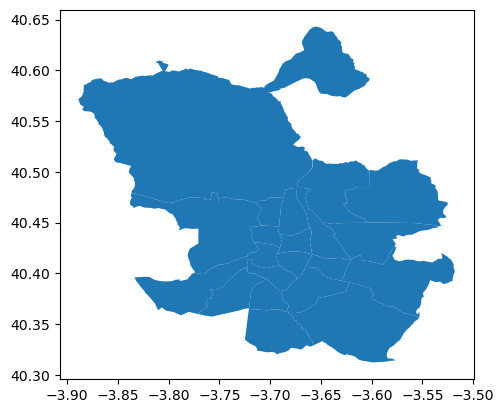

In [9]:
# Comprobar si podemos dibujar el mapa con los datos extraidos

distritos_madrid.plot()



Text(0.5, 1.0, 'Indice de Vulnerabilidad Territorial Agregado por distrito, Madrid 2020')

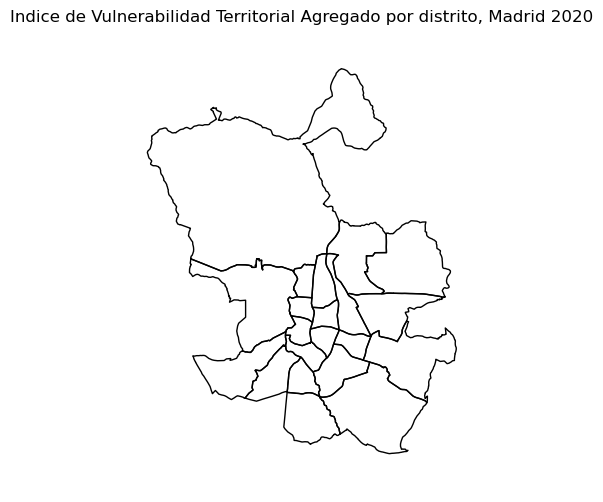

In [10]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

gplt.polyplot(distritos_madrid, projection=gcrs.AlbersEqualArea(central_longitude=-3.70, central_latitude=40.42))

plt.title("Indice de Vulnerabilidad Territorial Agregado por distrito, Madrid 2020")

### Gráfica Cartograma sin contigüidad

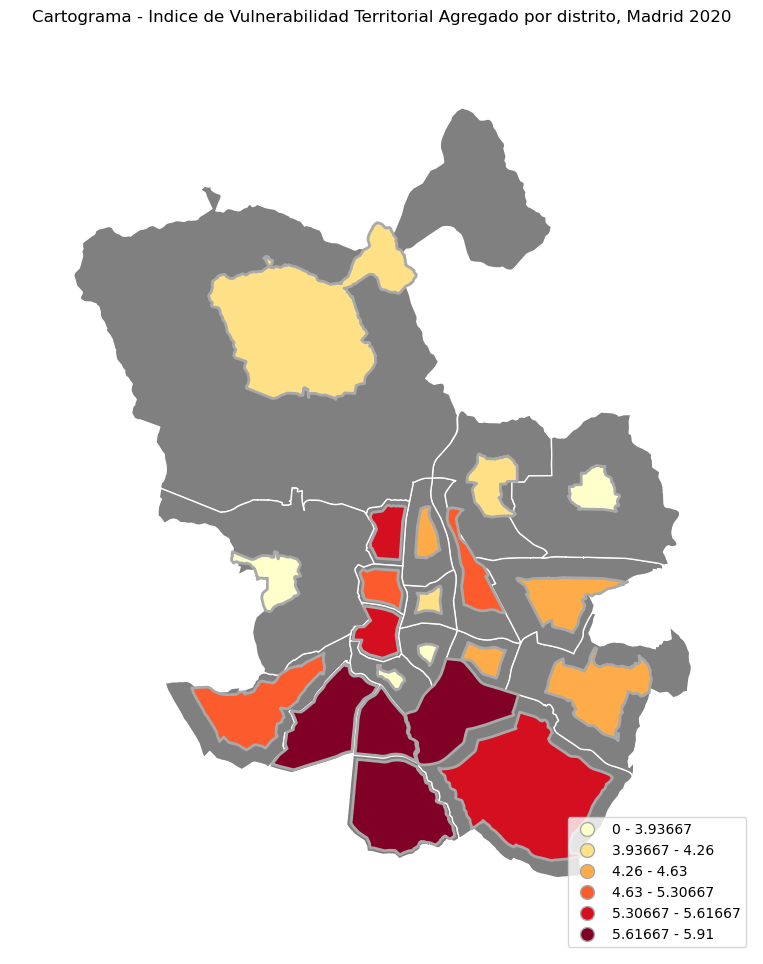

In [11]:
scheme = mc.Quantiles(distritos_madrid['IVTA'], k=6)

ax = gplt.cartogram(
    distritos_madrid,
    scale='IVTA', limits=(0.3, 1),
    projection=gcrs.AlbersEqualArea(central_longitude=-3.70, central_latitude=40.42),
    hue='IVTA', cmap='YlOrRd', scheme=scheme,
    linewidth=2,
    legend=True, legend_kwargs={'loc': 'lower right'}, legend_var='hue', edgecolor='darkgray',
    figsize=(15, 12)
)

gplt.polyplot(distritos_madrid, facecolor='gray', edgecolor='white', ax=ax)

plt.title("Cartograma - Indice de Vulnerabilidad Territorial Agregado por distrito, Madrid 2020")
plt.savefig('visualization/cartograma.png')
plt.show()

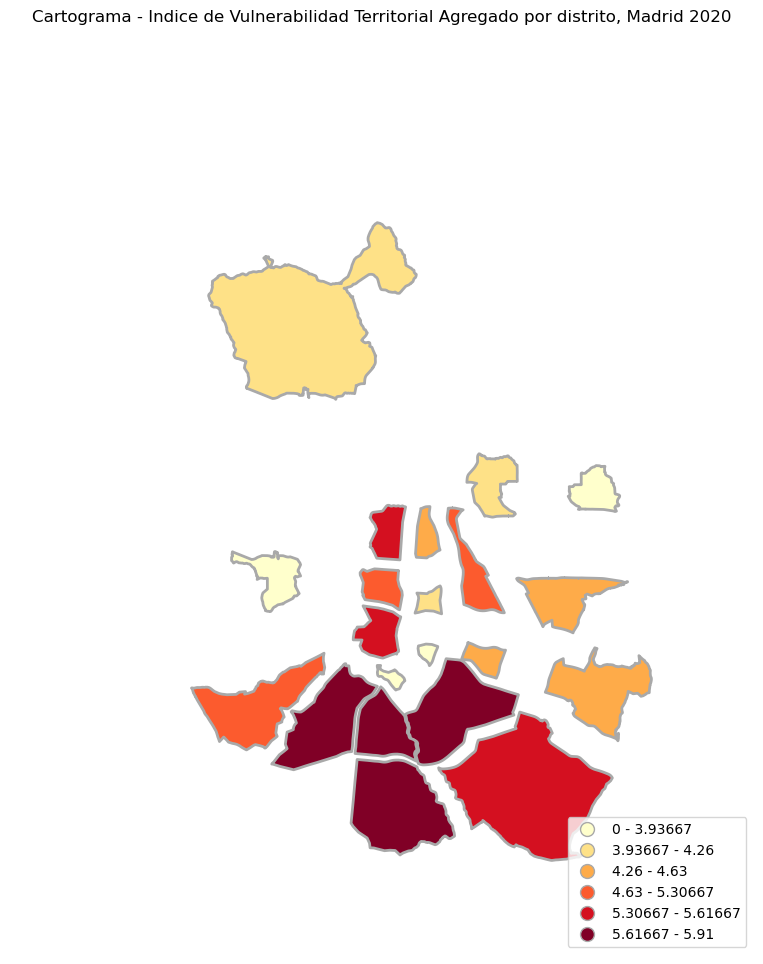

In [12]:
scheme = mc.Quantiles(distritos_madrid['IVTA'], k=6)

ax = gplt.cartogram(
    distritos_madrid,
    scale='IVTA', limits=(0.3, 1),
    projection=gcrs.AlbersEqualArea(central_longitude=-3.70, central_latitude=40.42),
    hue='IVTA', cmap='YlOrRd', scheme=scheme,
    linewidth=2,
    legend=True, legend_kwargs={'loc': 'lower right'}, legend_var='hue', edgecolor='darkgray',
    figsize=(15, 12)
)

plt.title("Cartograma - Indice de Vulnerabilidad Territorial Agregado por distrito, Madrid 2020")
plt.savefig('visualization/cartograma_sin_mapa_de_fondo.png')
plt.show()

## Parallel Coordinates Plot

Para este ejemplo vamos a emplear:

- La librería Plotly Express para generar un gráfico interactivo
- Datos del índice de vulnerabilidad territorial y sus distintas dimensione, que hemos visto en el ejemplo anterior

In [13]:
# vulnerabilidad_raw.columns

In [32]:
import plotly.express as px
# Dependencia para guardar los gráficos en formato estático
# import kaleido


fig = px.parallel_coordinates(vulnerabilidad_raw, #color="Codigo distrito",
                              dimensions=['Indice de Vulnerabilidad Territorial Agregado', 'Índice de Vulnerabilidad Bienestar Social e Igualdad', 
                              'Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad', 'Índice de Vulnerabilidad Educación y Cultura',
                              'Índice de Vulnerabilidad Economía y Empleo','Índice de Vulnerabilidad Salud'],
                              labels = {'Indice de Vulnerabilidad Territorial Agregado': 'Agregado', 'Índice de Vulnerabilidad Bienestar Social e Igualdad': 'Social e igualdad',
                                'Índice de Vulnerabilidad Medio Ambiente Urbano y Movilidad': 'Medio ambiente y movilidad', 'Índice de Vulnerabilidad Educación y Cultura': 'Educación y cultura',
                                'Índice de Vulnerabilidad Economía y Empleo': 'Economía y empleo', 'Índice de Vulnerabilidad Salud': 'Salud'},
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2,
                              title='Parallel coordinates-Indice de Vulnerabilidad Territorial Agregado por distrito, Madrid 2020')

#fig.write_image("visualization/paralell_coordinates.png")
fig.write_html("visualization/paralell_coordinates.html")
fig.show()


## Connected Scatterplot

Existen dos tipos de connected scatterplot. Uno que es como un lineplot, en el que se muestran con un marcador los puntos donde se han tomado las medidas (que se emplea para ver con mayor claridad la evaluación de un valor a lo largo del tiempo). También se puede entender como un scatterplot en el que los puntos se han unido con lineas para ayudar a visualizar las tendencias entre dos puntos diferentes.

Este tipo de conncted scatterplot requiere de una variable temporal (eje x) y de una variable numérica (eje y). Este tipo de gráfica se puede generar con Matplotlib.

### Preparación de los datos

In [15]:
# Inspirado en los ejemplos publicados en https://www.python-graph-gallery.com/connected-scatter-plot/

if not os.path.exists('data/external/coin_Bitcoin.csv'): 
    url_cryptoprices = 'https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory/download?datasetVersionNumber=3'
    r = requests.get(url_cryptoprices, allow_redirects=True)
    open('data/external/cryptoprices.zip', 'wb').write(r.content)

    # unzip distritos_madrid.zip
if not os.path.exists('data/external/coin_Bitcoin.csv'):
    with zipfile.ZipFile('data/external/archive.zip', 'r') as zip_ref:
        zip_ref.extractall('data/external/')

# Saltamos las filsa del encabezado, y le indicamos que la coma es el separador de decimales
precios_bitcoin_raw = pd.read_csv('data/external/coin_Bitcoin.csv', parse_dates=['Date'])

precios_bitcoin_raw.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [16]:
precios_bitcoin_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2991 non-null   int64         
 1   Name       2991 non-null   object        
 2   Symbol     2991 non-null   object        
 3   Date       2991 non-null   datetime64[ns]
 4   High       2991 non-null   float64       
 5   Low        2991 non-null   float64       
 6   Open       2991 non-null   float64       
 7   Close      2991 non-null   float64       
 8   Volume     2991 non-null   float64       
 9   Marketcap  2991 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 233.8+ KB


In [17]:
precios_bitcoin_raw['Date'].min(), precios_bitcoin_raw['Date'].max()

(Timestamp('2013-04-29 23:59:59'), Timestamp('2021-07-06 23:59:59'))

In [18]:
# Calculamos los precios medios por año
precios_bitcoin = precios_bitcoin_raw.groupby(precios_bitcoin_raw['Date'].dt.year).mean().reset_index()
precios_bitcoin['Coin'] = 'Bitcoin'
precios_bitcoin.head(10)

,Date,SNo,High,Low,Open,Close,Volume,Marketcap,Coin
0,2013,124.0,269.862232,240.087526,255.633097,257.973504,5.667401e+05,3.066581e+09,Bitcoin
1,2014,430.0,540.311721,514.366944,528.404704,527.236459,2.509365e+07,6.782807e+09,Bitcoin
2,2015,795.0,278.151978,266.807891,272.149011,272.453381,3.390557e+07,3.922142e+09,Bitcoin
3,2016,1160.5,574.302273,560.453374,567.141429,568.492407,8.592451e+07,8.929758e+09,Bitcoin
4,2017,1526.0,4144.687445,3811.707792,3970.644848,4006.033629,2.382867e+09,6.645752e+10,Bitcoin
5,2018,1891.0,7787.978968,7350.747934,7601.018676,7572.298943,6.063552e+09,1.292673e+11,Bitcoin
6,2019,2256.0,7549.907402,7222.602884,7385.218462,7395.246281,1.673049e+10,1.319457e+11,Bitcoin
7,2020,2621.5,11304.359059,10844.595149,11056.787200,11116.378080,3.302327e+10,2.049175e+11,Bitcoin
8,2021,2898.0,47025.740478,43692.138738,45514.300100,45539.275876,6.038306e+10,8.503084e+11,Bitcoin


### Gráfica Connected Scatterplot con una variable

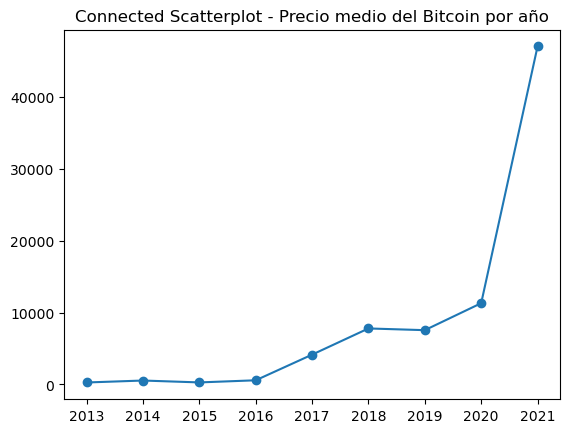

In [19]:
# El connected scatterplot comparado con un scatterplot normal, permite visualizar mejor las tendencias. En nuestro ejemplo, podemos ver el crecimiento acentuado entre el año 2020 y 2021, así como la poca diferencia entre los años 208 y 2019.
# En este caso los puntos ayudan a identificar los valores de cada año, pero no son necesarios para la visualización de la tendencia, como veremos con el siguiente ejemplo.

# Connected Scatterplot
plt.plot('Date', 'High', data=precios_bitcoin, linestyle='-', marker='o')
plt.title('Connected Scatterplot - Precio medio del Bitcoin por año')
plt.savefig('visualization/connected_scatterplot_una_variable.png')
plt.show()

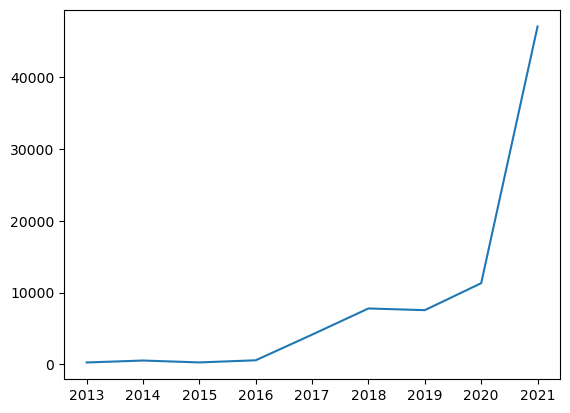

In [20]:
# line plot sin marcadores. Podemos apreciar la tendencia, pero no se ve de forma tan clara el años.
plt.plot('Date', 'High', data=precios_bitcoin)
plt.show()

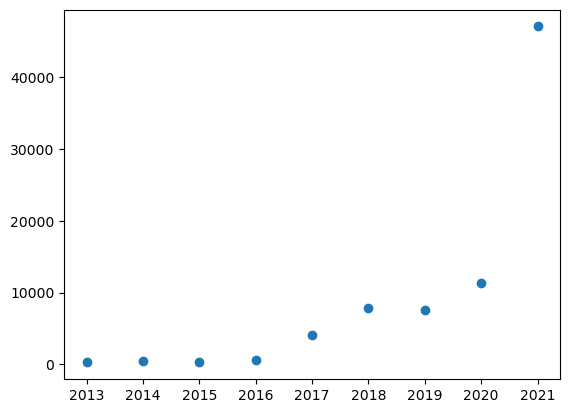

In [21]:
# En el caso del scatterplot, no se aprecia tan bien la tendencia, pero sí los valores de cada año. Por ejemplo, en los años 2018, 2019 y 2020, líneas del connected scatter plot nos ayudan a detectar mejor los cambios más sutiles entre los distintos años.

plt.scatter('Date', 'High', data=precios_bitcoin, marker='o')
plt.show()

También con este mismo nombre podemos encontrar un segundo tipo de gráfica que mapear a la evolución de dos variables a lo largo de una escala temporal. Este tipo de gráficas puede resultar bastante confuso, por lo que se recomienda siempre utilizar flechas para indicar la dirección en la que se mueve el gráfico ya qué el tiempo puede moverse tanto de izquierda derecha como de derecha izquierda.

Para dibujar este tipo de variables vamos a necesitar dos variables de tipo numérico y una tercera variable utilizada para la escala temporal. Tomando el ejemplo anterior vamos a visualizar también el precio del Ethereum, otra criptomoneda, para si las fluctuaciones de una moneda afectan a al otra respecto a su tasa de cambio de podinero ordinario.

In [22]:
# Inspirado en los ejemplos publicados en https://www.python-graph-gallery.com/connected-scatterplot-for-evolution

# import dataset
precios_ethereum_raw = pd.read_csv('data/external/coin_Ethereum.csv', parse_dates=['Date'])



In [23]:
precios_ethereum_raw['Date'].min(), precios_ethereum_raw['Date'].max()

(Timestamp('2015-08-08 23:59:59'), Timestamp('2021-07-06 23:59:59'))

In [24]:
# Calculamos los precios medios por año
precios_ethereum = precios_ethereum_raw.groupby(precios_ethereum_raw['Date'].dt.year).mean().reset_index()
precios_ethereum['Coin'] = 'Ethereum'
precios_ethereum.head(10)

,Date,SNo,High,Low,Open,Close,Volume,Marketcap,Coin
0,2015,73.5,0.998818,0.873981,0.943310,0.930201,8.244728e+05,6.788300e+07,Ethereum
1,2016,329.5,10.138809,9.365936,9.763721,9.778040,1.797756e+07,8.033392e+08,Ethereum
2,2017,695.0,232.438123,212.109213,221.935485,223.915208,7.432752e+08,2.116943e+10,Ethereum
3,2018,1060.0,502.704094,463.143234,485.397384,483.507726,2.276869e+09,4.797184e+10,Ethereum
4,2019,1425.0,186.367671,176.947580,181.771947,181.770138,6.967028e+09,1.941340e+10,Ethereum
5,2020,1790.5,315.010120,297.221470,305.899434,307.542978,1.424528e+10,3.450080e+10,Ethereum
6,2021,2067.0,2164.369320,1958.761443,2068.592976,2077.092620,3.410404e+10,2.399109e+11,Ethereum


In [25]:
precios_bitcoin.head()

,Date,SNo,High,Low,Open,Close,Volume,Marketcap,Coin
0,2013,124.0,269.862232,240.087526,255.633097,257.973504,5.667401e+05,3.066581e+09,Bitcoin
1,2014,430.0,540.311721,514.366944,528.404704,527.236459,2.509365e+07,6.782807e+09,Bitcoin
2,2015,795.0,278.151978,266.807891,272.149011,272.453381,3.390557e+07,3.922142e+09,Bitcoin
3,2016,1160.5,574.302273,560.453374,567.141429,568.492407,8.592451e+07,8.929758e+09,Bitcoin
4,2017,1526.0,4144.687445,3811.707792,3970.644848,4006.033629,2.382867e+09,6.645752e+10,Bitcoin


In [26]:
# contatenamos los dos dataframes
precios_criptomonedas = pd.concat([precios_bitcoin, precios_ethereum], axis=0)
precios_criptomonedas.sample(3)

,Date,SNo,High,Low,Open,Close,Volume,Marketcap,Coin
0,2013,124.0,269.862232,240.087526,255.633097,257.973504,5.667401e+05,3.066581e+09,Bitcoin
8,2021,2898.0,47025.740478,43692.138738,45514.300100,45539.275876,6.038306e+10,8.503084e+11,Bitcoin
3,2018,1060.0,502.704094,463.143234,485.397384,483.507726,2.276869e+09,4.797184e+10,Ethereum


In [27]:
# filter data
# precios_criptomonedas = precios_criptomonedas.loc[(precios_criptomonedas.Coin"Ashley") | (df.name=="Amanda")]
precios_criptomonedas = precios_criptomonedas.loc[precios_criptomonedas['Date']>2014]
precios_criptomonedas = pd.pivot_table(precios_criptomonedas, values='High', index=['Date'], columns=['Coin'])

precios_criptomonedas.head(10)



Coin,Bitcoin,Ethereum
Date,,
2015,278.151978,0.998818
2016,574.302273,10.138809
2017,4144.687445,232.438123
2018,7787.978968,502.704094
2019,7549.907402,186.367671
2020,11304.359059,315.010120
2021,47025.740478,2164.369320


In [28]:
precios_criptomonedas.shape[0]

7

### Gráfica Connected Scatterplot con dos variables

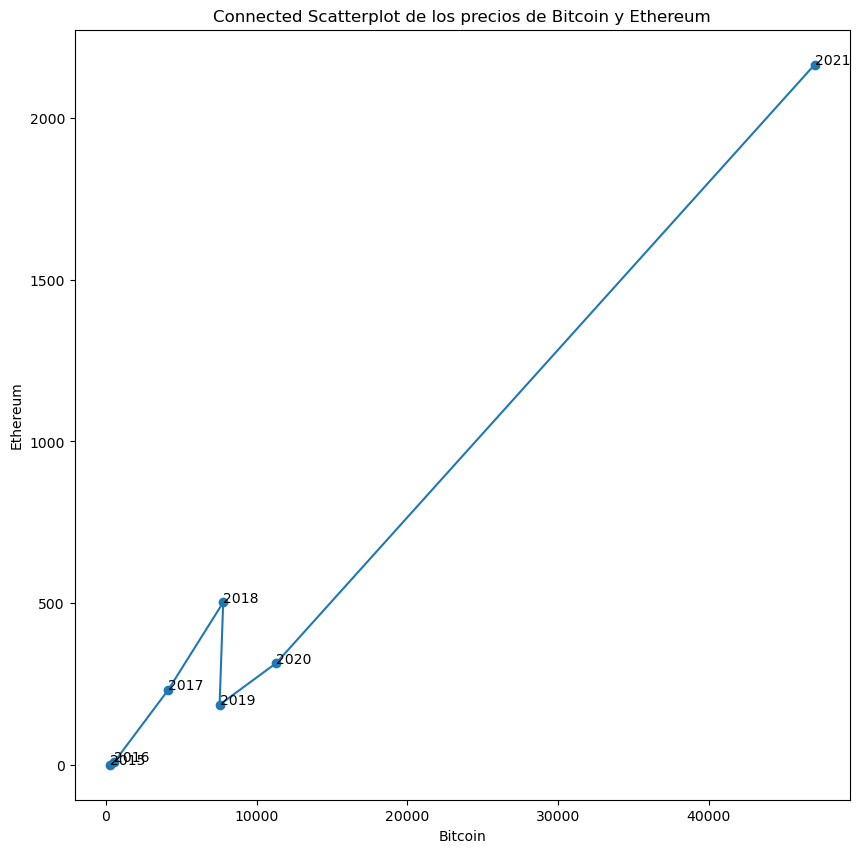

In [29]:
plt.figure(figsize=(10, 10))

# plot the connected scatterplot
plt.plot(precios_criptomonedas.Bitcoin, precios_criptomonedas.Ethereum, '-', marker='o')

for x, y, z in zip(precios_criptomonedas.Bitcoin, precios_criptomonedas.Ethereum, precios_criptomonedas.index):
    plt.text(x, y, z)

plt.title('Connected Scatterplot de los precios de Bitcoin y Ethereum')
plt.xlabel('Bitcoin')
plt.ylabel('Ethereum')
plt.savefig('visualization/connected_scatterplot_dos_variables.png')
plt.show()

[]

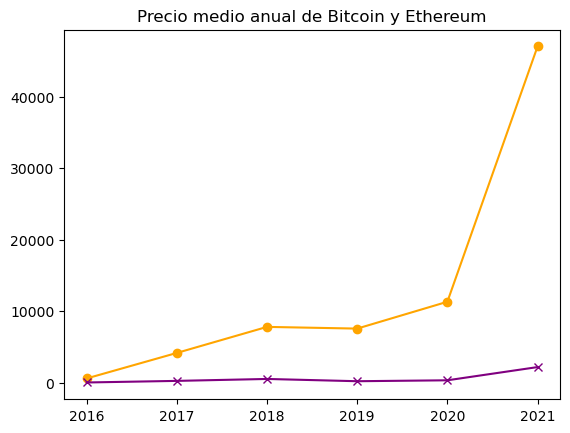

In [30]:
# Comparativa con un scatterplot normal con ambas variables separadas
plt.plot('Date', 'High', data=precios_bitcoin[precios_bitcoin['Date']>2015], linestyle='-', marker='o', color='orange')
plt.plot('Date', 'High', data=precios_ethereum[precios_ethereum['Date']>2015], linestyle='-', marker='x', color='purple')
plt.title('Precio medio anual de Bitcoin y Ethereum')
plt.plot()

[]

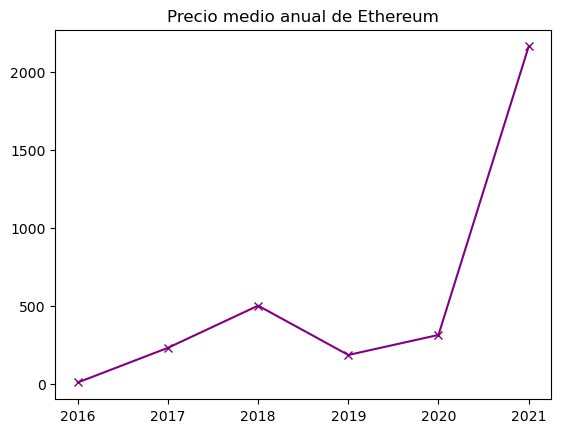

In [31]:
# Comparativa con un connected scatterplot que sólo muestra el valor de Ethereum
plt.plot('Date', 'High', data=precios_ethereum[precios_ethereum['Date']>2015], linestyle='-', marker='x', color='purple')
plt.title('Precio medio anual de Ethereum')
plt.plot()